# Zillow Home Values

In [2]:
## standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
SEED = 321
np.random.seed(SEED)

# Part 1


- Load the provided joblib file. Display the .keys of the dictionary stored in the joblib file.

In [3]:
loaded_joblib = joblib.load("Data/saved_model.joblib")
loaded_joblib.keys()

c:\Users\clove\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\clove\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\clove\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.1.3. This might lead to breaking code or in

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])

- Assign each of the keys from the dictionary as a separate variable.

In [4]:
## Saving the dictionary data into separate variables
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test  = loaded_joblib['X_test']
y_test  = loaded_joblib['y_test']
##  Saving the model and processing tools to new vars
rf_reg  = loaded_joblib['RandomForestRegressor']
lin_reg  = loaded_joblib['LinearRegression'] 

preprocessor = loaded_joblib['preprocessor']

- Use the preprocessor to transform the X_train/X_test data into processed dataframes. 

In [5]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                        columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
343,13860.0,75.0,7.0,1952.0,2704.0,9.0,1.0,0.0,0.0,0.0,1.0
1413,8405.0,50.0,8.0,861.0,1367.0,7.0,1.0,0.0,0.0,0.0,1.0
2583,11310.0,75.0,5.0,1367.0,1375.0,5.0,1.0,0.0,0.0,0.0,1.0


## Explain the Linear Regression Model:
- Extract the coefficients and save them as a Series with the correct feature names as the index.

In [6]:
# define linreg function 
def evaluate_regression(model, X_train,y_train, X_test, y_test):    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:,.2f}")
#change for applicable criteria                                   ^^^  separator for thousands/ 2 decimal places
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:,.2f}")
#change for applicable criteria                              ^^^  separator for thousands/ 2 decimal places
# define  coef grabber function
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                    name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [7]:
## fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.66	RMSE= 47,743.32
Test Data:	R^2= 0.66	RMSE= 42,544.20


- Create a bar graph of the coefficients, sorted from largest to smallest. 

In [8]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                    textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.2f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n (sorted from largest to smallest.)
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
        ylabel='Feature Names', 
        title=title)
    ax.axvline(0, color='k')
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                    textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def plot_coeffs_negative(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude--negatively"
    else:
        ## rank the coeffs and select the top_n (sorted from largest to smallest.)
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values(ascending=False)
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Negative Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
        ylabel='Feature Names', 
        title=title)
    ax.axvline(0, color='k')
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                    textcoords=textcoords)
    return ax

In [9]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Land Contour_Bnk   -34132.469944
TotRms AbvGrd       -6299.906977
Land Contour_Low    -4822.964130
Land Contour_Lvl    -3776.189774
Lot Area                0.107876
Total Bsmt SF          59.753976
Gr Liv Area           101.283754
Lot Frontage          109.311338
Overall Cond         1737.313325
Central Air_Y       31927.224382
Land Contour_HLS    42731.623848
dtype: float64

<Axes: title={'center': 'Top 10 Largest Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

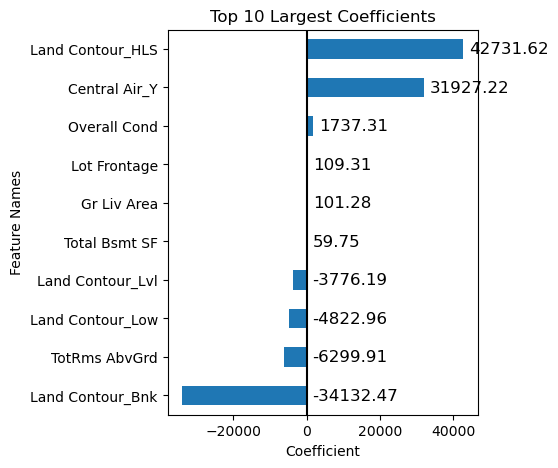

In [10]:
plot_coeffs(coeffs,top_n=10, annotate=True)

- Provide a quantitative interpretation (both magnitude and directionality) of the three largest positive coefficients explaining how that feature impacts the target.

-  target is home value


    - Top 3 Positive Coeffs.
        1. If the prospective homes Land Contour falls into the hillside category, an additional 42,731.62  can be predicted to its value.
        2. if the perspective home  HAS central air conditioning, an additional 31,927.22 can be predicted to its value.
        3. for every point increase to the overall condition of the home, an additional 1,737.31 can be predicted to its value.



<Axes: title={'center': 'Top 10 Negative Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

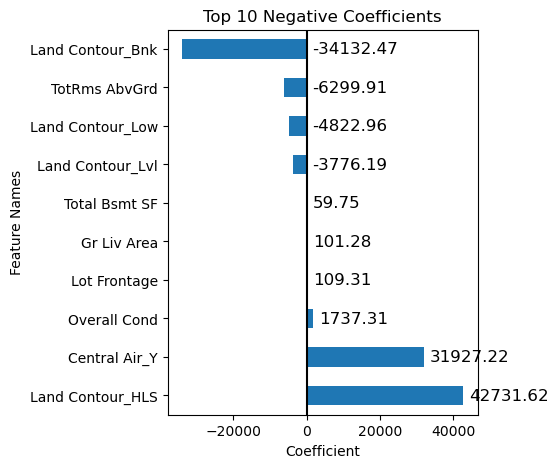

In [11]:
plot_coeffs_negative(coeffs, top_n=10,annotate=True)

- Provide a quantitative interpretation (both magnitude and directionality)  of the three largest negative coefficients explaining how that feature impacts the target.

    - Top 3 Negative Coeffs.
        1. if the prospective homes Land Contour falls into the banked category, an expected loss of 34,132.47 can be predicted to its value.
        2. For every point increase to the total rooms above grade, an expected loss of 6,299.90 can be predicted to its value.
        3. If the prospective homes Land Contour falls into the low depression category, an expected loss of 4,822.96 can be predicted to its value.

# Explain the Random Forest Model:
- Extract and create a bar graph of the feature importances, sorted from largest to smallest. 

In [12]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.97	RMSE= 14,789.90
Test Data:	R^2= 0.78	RMSE= 34,620.40


In [13]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

11
11


True

- What are the top 6 most important features? 

In [14]:
importances = pd.Series(reg.feature_importances_, index= feature_names,name='Feature Importance')
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Gr Liv Area         0.437332
Total Bsmt SF       0.362180
Lot Area            0.052514
Lot Frontage        0.048636
TotRms AbvGrd       0.033980
Overall Cond        0.032908
Central Air_Y       0.014350
Land Contour_HLS    0.008347
Land Contour_Bnk    0.006264
Land Contour_Lvl    0.002983
Land Contour_Low    0.000506
Name: Feature Importance, dtype: float64

- plot the top 6 for visual clerification

<Axes: >

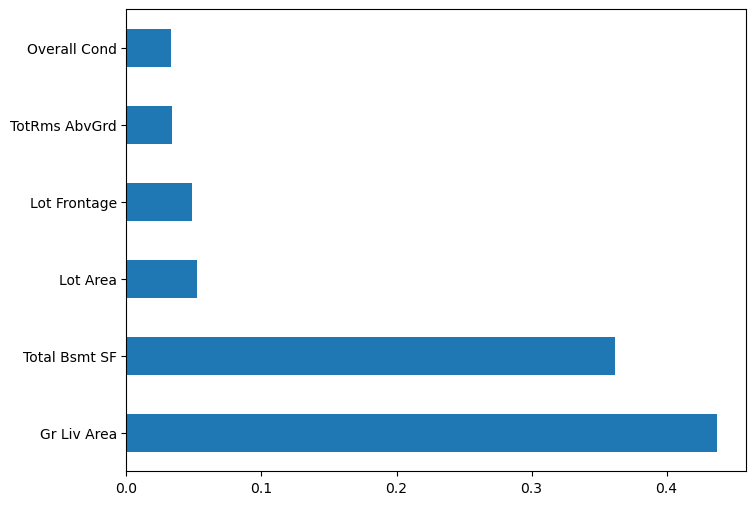

In [15]:
sorted_importance.head(6).plot(kind='barh',figsize=(8,6))

### top 6 features
    1. Gr Liv Area  
    2. Total Bsmt SF
    3. Lot Area
    4. Lot Frontage
    5. TotRms AbvGrd
    6. Overall Cond 

- Of the top 6 most important features, identify which of these features also appeared in the 3 largest or 3 smallest coefficients. 

    - Total rooms above grade.
    - overall condition.





## Apply Shap to Explain the Random Forest Model

In [16]:
import shap
shap.initjs()

- Sample 500 rows of the processed X_train data as X_shap, using random_state=321

In [17]:
X_shap = shap.sample(X_train_df,nsamples=500,random_state=321)
X_shap

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
297,19645.0,85.000000,6.0,423.0,1652.0,6.0,1.0,0.0,0.0,0.0,1.0
2846,8400.0,60.000000,5.0,940.0,1595.0,6.0,1.0,1.0,0.0,0.0,0.0
1319,5700.0,69.230685,7.0,572.0,1111.0,5.0,1.0,0.0,0.0,0.0,1.0
1570,164660.0,69.230685,6.0,1499.0,1786.0,7.0,1.0,0.0,1.0,0.0,0.0
1139,8453.0,65.000000,5.0,754.0,1609.0,6.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2498,14330.0,100.000000,4.0,1748.0,2646.0,9.0,1.0,0.0,0.0,1.0,0.0
2357,10140.0,78.000000,6.0,1040.0,1309.0,5.0,1.0,0.0,0.0,0.0,1.0
564,11949.0,69.230685,8.0,975.0,1755.0,7.0,1.0,0.0,0.0,0.0,1.0
2282,32463.0,69.230685,4.0,1249.0,1622.0,7.0,1.0,0.0,0.0,1.0,0.0


- Save the corresponding y_train values as y_shap

In [18]:
y_shap = y_train.loc[X_shap.index].astype(int)
y_shap

297     203135
2846    140000
1319    116900
1570    228950
1139    182000
         ...  
2498    260000
2357    181000
564     235000
2282    168000
2080    118000
Name: SalePrice, Length: 500, dtype: int32

In [19]:
# reset indexes
X_shap = X_shap.reset_index(drop=True)
y_shap = y_shap.reset_index(drop=True)

- Create a shap model explainer for the random forest model

In [20]:
explainer = shap.Explainer(rf_reg)
explainer

- Calculate the shap values for the sampled data

In [21]:
shap_values = explainer(X_shap)

- Create a summary plot (plot_type =’dot’) of the most important features, according to shap.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


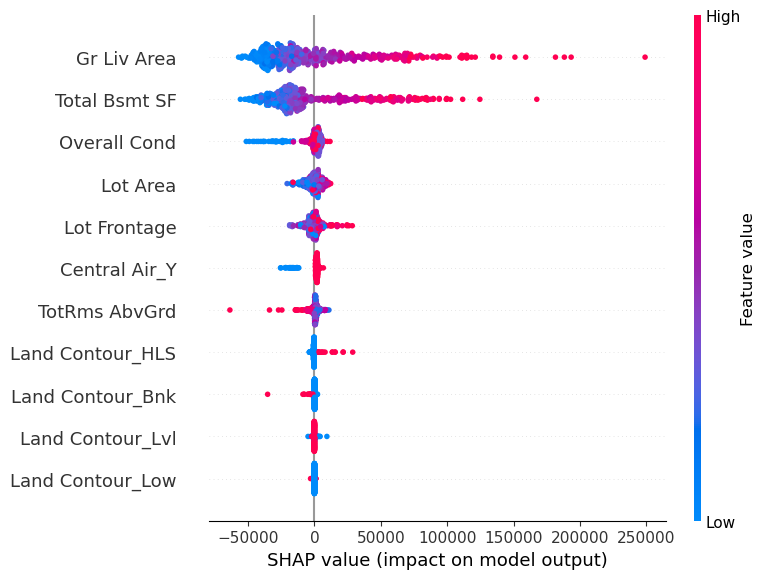

In [22]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, plot_type='dot')

- Interpret the top 6 most important features. According to shap, what effect does each feature have on the model’s prediction?
    1. Gr Liv Area- The more living area (SQft)above grade a home has(red), the more likely it will positively impact the prediction value.
    2. Total Bsmt SF - the larger a basement in a home(Red), the more likely it will positively impact the prediction value.
    3. Overall Cond- the lower the rating of the condition of the home(blue), the more likely it will negativly impact the prediction value. While a higher rating does positivly impact the model, the negative impact of a lower rating outvalues  having a higher rating.
    4. Lot Area- a central cluster of mixed values would indicate a less than average impact in either direction on the predicted value.
    5. Lot Frontage- The more linear feet of street connected to the property(Red) the more likely it is to positively impact the model. 
    6. Central Air Y- if the home DOES have central air, it is likely to positively impact the model.

# Part 2

- Load the provided csv, located in the zip file you downloaded in Part 1.

In [23]:
fpath=('Data/zillow_home_values-zipcode.csv')
df= pd.read_csv(fpath)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


- Prepare the data as a time series DataFrame:
    - Melt the wide-form data into a long-form time series.
    - The date column should be named “Date”
    - The value column should be named “Home Value”

In [24]:
# drop unnecessary cols before the melt.   
drop_cols=['RegionID','SizeRank','RegionType','StateName','Metro']
df=df.drop(columns=drop_cols)
df

,RegionName,State,City,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,77449,TX,NaN,Harris County,107261.0,107274.0,107076.0,107081.0,107112.0,107325.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,77494,TX,NaN,Fort Bend County,222569.0,222885.0,223602.0,224818.0,224384.0,224051.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,79936,TX,El Paso,El Paso County,90009.0,90009.0,90042.0,90007.0,90027.0,89987.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,11368,NY,New York,Queens County,188096.0,190588.0,192155.0,194686.0,196246.0,198131.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,11385,NY,New York,Queens County,275983.0,277855.0,279802.0,282271.0,283679.0,284880.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27437,50160,IA,Martensdale,Warren County,NaN,NaN,NaN,NaN,NaN,NaN,...,179118.0,180140.0,181125.0,182326.0,184931.0,186807.0,188354.0,190188.0,191768.0,193591.0
27438,18081,PA,Hellertown,Bucks County,NaN,NaN,NaN,NaN,NaN,NaN,...,358872.0,364462.0,370884.0,374839.0,375156.0,374141.0,372143.0,371578.0,372879.0,376523.0
27439,55366,MN,NaN,Sibley County,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110082.0
27440,51009,IA,Calumet,O Brien County,NaN,NaN,NaN,NaN,NaN,NaN,...,72574.0,73121.0,73348.0,73553.0,74544.0,75369.0,75727.0,75402.0,75650.0,75810.0


In [25]:
melted = pd.melt(df,id_vars=['RegionName','State','City','CountyName'],
                value_name='HomeValue',var_name="Date" )

melted

,RegionName,State,City,CountyName,Date,HomeValue
0,77449,TX,NaN,Harris County,31012000,107261.0
1,77494,TX,NaN,Fort Bend County,31012000,222569.0
2,79936,TX,El Paso,El Paso County,31012000,90009.0
3,11368,NY,New York,Queens County,31012000,188096.0
4,11385,NY,New York,Queens County,31012000,275983.0
...,...,...,...,...,...,...
7546545,50160,IA,Martensdale,Warren County,30112022,193591.0
7546546,18081,PA,Hellertown,Bucks County,30112022,376523.0
7546547,55366,MN,NaN,Sibley County,30112022,110082.0
7546548,51009,IA,Calumet,O Brien County,30112022,75810.0


 - Convert the Date column to a Datetime index.

In [26]:
melted['Date'] = pd.to_datetime(melted['Date'] ,format='%d%m%Y')

- Set the Date column as the index

In [27]:
melted = melted.set_index("Date")
melted

,RegionName,State,City,CountyName,HomeValue
Date,,,,,
2000-01-31,77449,TX,NaN,Harris County,107261.0
2000-01-31,77494,TX,NaN,Fort Bend County,222569.0
2000-01-31,79936,TX,El Paso,El Paso County,90009.0
2000-01-31,11368,NY,New York,Queens County,188096.0
2000-01-31,11385,NY,New York,Queens County,275983.0
...,...,...,...,...,...
2022-11-30,50160,IA,Martensdale,Warren County,193591.0
2022-11-30,18081,PA,Hellertown,Bucks County,376523.0
2022-11-30,55366,MN,NaN,Sibley County,110082.0


- Filter the data:
    - Keep data from the following states:  CA, WA, OR, AZ, NV

In [28]:
keepers=['CA', 'WA', 'OR', 'AZ', 'NV']
filtered_ts=melted[melted['State'].isin(keepers)]
filtered_ts['State'].value_counts()

CA    432575
WA    145475
OR    100375
AZ     88275
NV     39325
Name: State, dtype: int64

- Keep values from the years  2010 - 2020.

In [29]:
filtered_ts.reset_index(inplace=True)
filtered_ts = filtered_ts[(filtered_ts['Date'] >= '2010-01-01')&(filtered_ts['Date'] <= '2020-12-31')]
filtered_ts = filtered_ts.set_index("Date")
filtered_ts

,RegionName,State,City,CountyName,HomeValue
Date,,,,,
2010-01-31,90011,CA,Los Angeles,Los Angeles County,209250.0
2010-01-31,91331,CA,Los Angeles,Los Angeles County,257372.0
2010-01-31,90650,CA,Norwalk,Los Angeles County,296430.0
2010-01-31,90201,CA,Bell,Los Angeles County,271829.0
2010-01-31,92335,CA,Fontana,San Bernardino County,156704.0
...,...,...,...,...,...
2020-12-31,95950,CA,Grimes,Colusa County,220881.0
2020-12-31,89041,NV,Pahrump,Nye County,NaN
2020-12-31,98623,WA,White Salmon,Klickitat County,538209.0


- Save the processed data as a  .csv file in a “Data” folder inside your private repo, name the csv “Data/data-for-tableau.csv”

In [30]:
filtered_ts.to_csv('Data/data-for-tableau.csv')

- Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.


In [31]:
df=filtered_ts.groupby('State').resample('AS', origin='start').mean()
df.head(20)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


RegionName      HomeValue
State Date                                   
AZ    2010-01-01  85550.336449  169930.889076
      2011-01-01  85550.336449  152272.467002
      2012-01-01  85550.336449  159902.057789
      2013-01-01  85550.336449  183657.225403
      2014-01-01  85550.336449  198551.492521
      2015-01-01  85550.336449  206834.173937
      2016-01-01  85550.336449  217452.799614
      2017-01-01  85550.336449  229066.028099
      2018-01-01  85550.336449  244689.172792
      2019-01-01  85550.336449  257396.582183
      2020-01-01  85550.336449  278841.942045
CA    2010-01-01  93598.652893  415491.808100
      2011-01-01  93598.652893  388468.031550
      2012-01-01  93598.652893  388593.634299
      2013-01-01  93598.652893  454509.845597
      2014-01-01  93598.652893  505808.423831
      2015-01-01  93598.652893  535297.119658
      2016-01-01  93598.652893  569319.272450
      2017-01-01  93598.652893  601938.428066
      2018-01-01  93598.652893  646936.553061

- Plot a line graph with each of the states as a separate line.

In [32]:
#unstack state names values
unstacked=df.unstack(level=0)
unstacked

RegionName                                            \
State                 AZ            CA            NV            OR   
Date                                                                 
2010-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2011-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2012-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2013-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2014-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2015-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2016-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2017-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2018-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2019-01-01  85550.336449  93598.652893  89265.237762  97394.490411   
2020-01-01  85550.336449  93598.652893  89265.237762  97394.490411   

                              HomeValue                                \
State                 WA             AZ             CA             NV   
Date                                                                    
2010-01-01  98603.703214  169930.889076  415491.808100  189285.319787   
2011-01-01  98603.703214  152272.467002  388468.031550  168931.537037   
2012-01-01  98603.703214  159902.057789  388593.634299  165003.293888   
2013-01-01  98603.703214  183657.225403  454509.845597  199847.532946   
2014-01-01  98603.703214  198551.492521  505808.423831  228975.139535   
2015-01-01  98603.703214  206834.173937  535297.119658  247372.119614   
2016-01-01  98603.703214  217452.799614  569319.272450  265123.976834   
2017-01-01  98603.703214  229066.028099  601938.428066  284543.217949   
2018-01-01  98603.703214  244689.172792  646936.553061  319753.462629   
2019-01-01  98603.703214  257396.582183  649531.475923  337914.425207   
2020-01-01  98603.703214  278841.942045  675124.170696  350564.885423   

                                          
State                  OR             WA  
Date                                      
2010-01-01  224035.019849  250932.487018  
2011-01-01  205273.042225  230557.026098  
2012-01-01  201899.022119  225432.142832  
2013-01-01  216964.502931  240848.444598  
2014-01-01  233022.531108  256869.916239  
2015-01-01  249633.916898  275704.942220  
2016-01-01  272424.454568  302116.532078  
2017-01-01  294524.759060  334494.267926  
2018-01-01  311491.056020  367370.462736  
2019-01-01  323800.937928  381711.638949  
2020-01-01  338782.970027  408430.209929

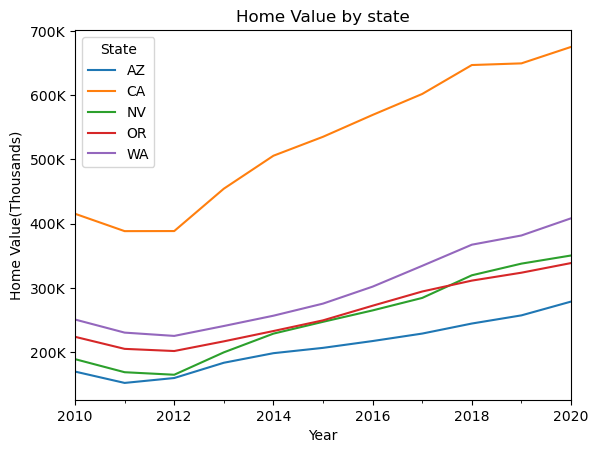

In [33]:
import matplotlib.ticker as mticks

def thousands(x,pos):
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# create formatter
fmt_thous = mticks.FuncFormatter(thousands)

ax=unstacked['HomeValue'].plot()
ax.yaxis.set_major_formatter(fmt_thous)
ax.set(title='Home Value by state',ylabel='Home Value(Thousands)',xlabel='Year');

# Part 3
## Tableau Workbook.

https://public.tableau.com/views/Zillow_Home_Values_16976877637840/Story1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link